In [117]:
import numpy as np 
from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astroquery.vizier import Vizier
import seaborn as sns

In [118]:
sns.set_context("talk")
sns.set_color_codes()

In [119]:
datapath = Path.cwd().parent / "data"

# Get celestial coordinates of proplyd sources

List of proplyds that we will work with:

In [169]:
proplyd_ids = [
    "177-341W",
    "180-331",
]

## Coordinates from SIMBAD (not accurate enough)

Use SIMBAD name service to get the coordinates of each source

In [104]:
cdict = {
    _: SkyCoord.from_name(f"[RRS2008] {_}")
    for _ in proplyd_ids
}

In [105]:
cdict

{'177-341w': <SkyCoord (ICRS): (ra, dec) in deg
     (83.82363747, -5.39468523)>,
 '180-331': <SkyCoord (ICRS): (ra, dec) in deg
     (83.82518623, -5.39187077)>}

In [107]:
cdict["177-341W"].to_string("hmsdms")

'05h35m17.67299252s -05d23m40.86682307s'

Even though we use the Ricci catalog ID to find the source, the SIMBAD coordinates _do not come from that catalog_. As a result, they are inaccurate by of order 0.2 arcsec, so we cannot use them

## Coordinates from Ricci 2008 catalog via Vizier

Get the coordinates of all proplyds in the first table of the catalog. Add the `Name` column as an index, so we can more efficiently look up individual sources. 

In [188]:
proplyd_tab = Vizier(
    catalog="J/AJ/136/2136",
    columns=['Name', '_RAJ2000', '_DEJ2000'],
    row_limit=-1,
).get_catalogs(    
    catalog="J/AJ/136/2136",
)[0]
proplyd_tab.add_index("Name")

Restrict to just the sources that we want:

In [189]:
proplyd_tab = proplyd_tab.loc[proplyd_ids]

If we make minor modifications to the RA, Dec column names, then `SkyCoord.guess_from_table()` can do its magic. Then we can remove the original columns. 

In [190]:
proplyd_tab.rename_columns(['_RAJ2000', '_DEJ2000'], ["ra_J2000", "dec_J2000"])
proplyd_tab["ICRS"] = SkyCoord.guess_from_table(proplyd_tab)
proplyd_tab.remove_columns(["ra_J2000", "dec_J2000"])

In [191]:
proplyd_tab

Name,ICRS
,"deg,deg"
str9,SkyCoord
177-341W,"83.8235833,-5.3947222"
180-331,"83.825125,-5.3918889"


# Look at image of some sources

In [215]:
fname = "f631n"
hdu = fits.open(datapath / f"align-pcmos-{fname}_sharp_16.fits")[0]

In [216]:
W = WCS(hdu.header)

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


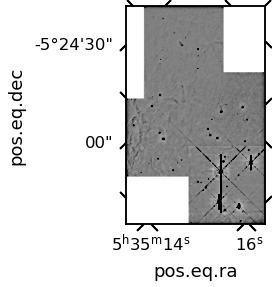

In [217]:
source = "177-341W"
#source = "180-331"
x0, y0 = proplyd_tab.loc[source]["ICRS"].to_pixel(W)
fig, ax = plt.subplots(subplot_kw=dict(projection=W))
ax.imshow(hdu.data, vmin=0, vmax=2, cmap="gray_r")

So, using imshow we always have the x, y axes aligned with the pixeaxes of the imegae. 

If we want to have it aligned with equatorial axes, then we will have to define an auxiliary WCS and then use pcolormesh instead of imshow.



In [218]:
ny, nx = 100, 100
pixscale = Angle("0.05 arcsec").deg
c = proplyd_tab.loc[source]["ICRS"]
wc = WCS(naxis=2)
wc.wcs.cdelt = [-pixscale, pixscale]
wc.wcs.crval = [c.ra.deg, c.dec.deg]
wc.wcs.crpix = [0.5 * (1 + nx), 0.5 * (1 + ny)]
wc.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [219]:
wc

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.8235833  -5.3947222  
CRPIX : 50.5  50.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.388888888888889e-05  1.388888888888889e-05  
NAXIS : 0  0

Now, we use upper case for the pixel coords and celestial coords of the big image grid

In [220]:
NY, NX = hdu.data.shape
X, Y = np.meshgrid(np.arange(NX), np.arange(NY))
CPIX = W.pixel_to_world(X, Y)

So CPIX is an array of same shape as hdu.data that contains celestial coordinates.

Check that if we convert them to pixels in our little aux frame that we have some near the origin

In [221]:
np.sum(np.hypot(*CPIX.to_pixel(wc)) < 50)

9608

[(0.0, 100.0), (0.0, 100.0)]

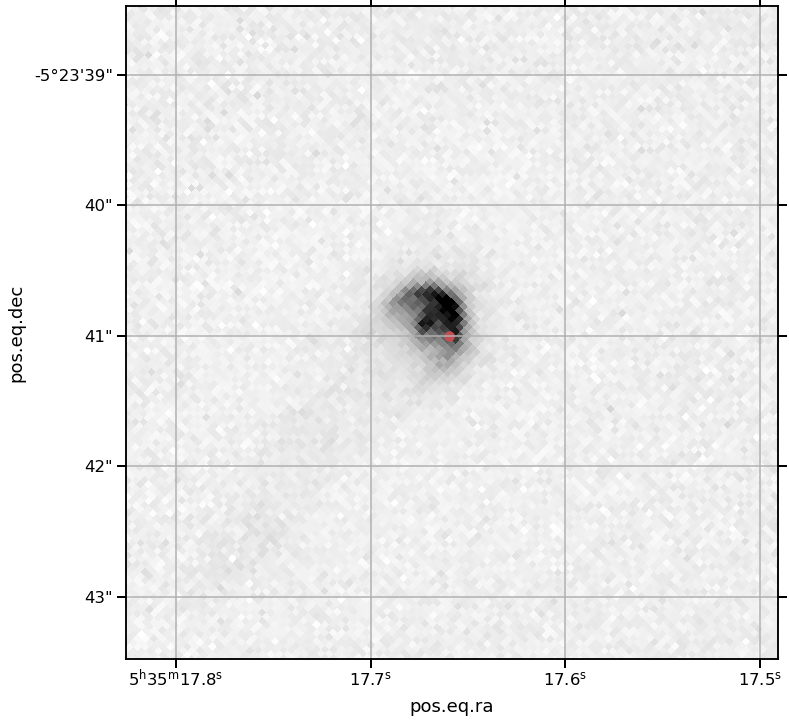

In [222]:
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw=dict(projection=wc),
)
T = ax.get_transform("world")
ax.pcolormesh(
    CPIX.ra.deg,
    CPIX.dec.deg,
    hdu.data, 
    vmin=0, 
    vmax=15, 
    cmap="gray_r",
    shading="nearest",
    transform=T,
)
ax.scatter(c.ra.deg, c.dec.deg, transform=T, color='r')
ax.set_aspect("equal")
ax.set(
    xlim=[0, nx],
    ylim=[0, ny],
)

In [229]:
proplyd_tab.loc[source]["ICRS"].to_string("hmsdms")

'05h35m17.659992s -05d23m40.99992s'

In [ ]:
proplyd_tab.loc[source]["ICRS"].to_string

So this shows that we can put the images at arbitrary axes if we use `pcolormesh` bt that the coordinates are not good enough from the catalogs. We have made our own list of coordinates instead.

# Read in list  of sources with my bespoke coordinates

These are specialized to the case of the PC mosaic, since the alignment with Robberto is still not perfect, even though I have done my best.

In [230]:
import regions

In [231]:
regfile = datapath / "pcmos-proplyds.reg"
regs = regions.Regions.read(datapath / regfile, format="ds9")

In [243]:
source_list = [{"Name": r.meta["label"],  "ICRS": r.center} for r in regs]

In [246]:
import pandas as pd
from astropy.table import Table

In [249]:
source_table = Table(source_list)
source_table

Name,ICRS
,"deg,deg"
str11,SkyCoord
177-341W,"83.82363499999998,-5.394699444444445"
173-341,"83.82216416666665,-5.394801388888889"
170-337,"83.82073749999998,-5.393605833333334"
171-340,"83.82105708333333,-5.394350833333334"
180-331,"83.82514916666666,-5.391885555555556"
176-325,"83.82313874999998,-5.390233888888889"
168-326,"83.82016916666666,-5.390601388888889"
161-328,"83.81696666666664,-5.391016944444445"


## Find PA to th1C

In [248]:
c0 = SkyCoord.from_name("* tet01 Ori C")

In [255]:
source_table["PA"] = source_table["ICRS"].position_angle(c0).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table.add_index("Name")

In [256]:
source_table

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
177-341W,"83.82363499999998,-5.394699444444445",314.98007715439655,25.432600010148143
173-341,"83.82216416666665,-5.394801388888889",325.26623943671575,22.321924813790307
170-337,"83.82073749999998,-5.393605833333334",331.55791584978465,15.967686371231176
171-340,"83.82105708333333,-5.394350833333334",332.3781956253825,18.873422933876565
180-331,"83.82514916666666,-5.391885555555556",288.5266971454808,24.69660035312236
176-325,"83.82313874999998,-5.390233888888889",276.6893443122159,16.322331463594164
168-326,"83.82016916666666,-5.390601388888889",300.0748250386534,6.4342047406945815
161-328,"83.81696666666664,-5.391016944444445",51.38552690888274,7.563771376918397


In [258]:
source_table.loc[source]

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
177-341W,"83.82363499999998,-5.394699444444445",314.98007715439655,25.432600010148143


In [259]:
ny, nx = 100, 100
pixscale = Angle("0.05 arcsec").deg
c = source_table.loc[source]["ICRS"]
wc = WCS(naxis=2)
wc.wcs.cdelt = [-pixscale, pixscale]
wc.wcs.crval = [c.ra.deg, c.dec.deg]
wc.wcs.crpix = [0.5 * (1 + nx), 0.5 * (1 + ny)]
wc.wcs.ctype = ["RA---TAN", "DEC--TAN"]

[(0.0, 100.0), (0.0, 100.0)]

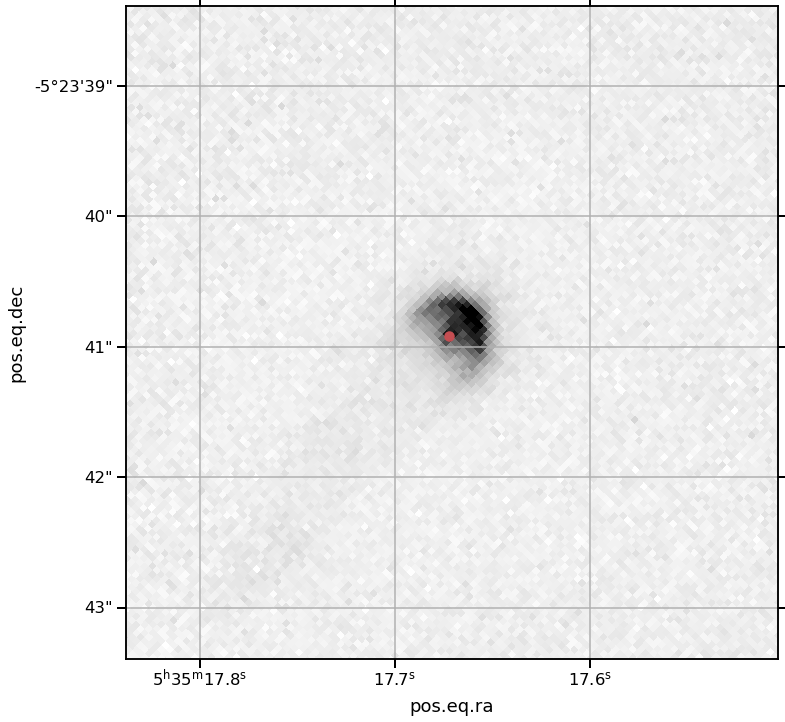

In [260]:
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw=dict(projection=wc),
)
T = ax.get_transform("world")
ax.pcolormesh(
    CPIX.ra.deg,
    CPIX.dec.deg,
    hdu.data, 
    vmin=0, 
    vmax=15, 
    cmap="gray_r",
    shading="nearest",
    transform=T,
)
ax.scatter(c.ra.deg, c.dec.deg, transform=T, color='r')
ax.set_aspect("equal")
ax.set(
    xlim=[0, nx],
    ylim=[0, ny],
)

In [261]:
ax.quiver?

Signature: ax.quiver(*args, data=None, **kw)
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], **kw)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color.

**Arrow size**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The defaults give a slightly swept-back arrow; to make the head a
triangle, make *headaxislength* the same as *headlength*. To make the
arrow more pointed, reduce *headwidth* or increase *headlength* and
*headaxislength*. To make the head smaller relative to the shaft,
scale down all the head parameters. You will probably do best to leave
minshaft alone.

**Arrow outline**

*linewidths* and *edgecolors* can be used to customize the arrow
outlines.

Parameters
----------
X, Y : 1D or 2D array-like, optional
    The x and y coordinates of the arrow locations.

   